In [100]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Read in Google date
df = pd.read_csv(r"C:\Users\hazze\OneDrive\Documents\DanceMad\dancemad_data_pipeline\process_data\google_data.csv", index_col=0)


In [101]:
# Look at head
df.head()


,name,formatted_address,rating,user_ratings_total,types,price_level,dance_type,city
0,Gonzalez y Gonzalez,"192 Mercer St, New York, NY 10012, United States",4.1,1820,"['restaurant', 'night_club', 'food', 'point_of...",2.0,Salsa,New York
1,Club Cache,"214 W 39th St, New York, NY 10018, United States",3.9,261,"['night_club', 'point_of_interest', 'establish...",NaN,Salsa,New York
2,Salsa Con Fuego,"2297 Cedar Ave, Bronx, NY 10468, United States",4.2,5711,"['bar', 'restaurant', 'food', 'point_of_intere...",2.0,Salsa,New York
3,Copacabana Nightclub,"625 W 51st St, New York, NY 10019, United States",3.5,631,"['night_club', 'point_of_interest', 'establish...",NaN,Salsa,New York
4,230 Fifth Rooftop Bar,"1150 Broadway, New York, NY 10001, United States",4.3,21498,"['night_club', 'bar', 'point_of_interest', 'es...",2.0,Salsa,New York


In [102]:
# Create city name mapping: city_name to shortform
def extract_capitals_or_first_three(input_string):
    # Extract capital letters from the string
    capital_letters = "".join([char for char in input_string if char.isupper()])
    
    # If there are fewer than three capital letters, take as many as there are, else take three
    if len(capital_letters) < 2:
        return input_string[:3]
    else:
        return capital_letters
    
city_sf = [extract_capitals_or_first_three(x) for x in df['city'].unique()]

city_mapping = dict(zip(df['city'].unique(), city_sf))

# Check mapping values is the same length as cities, to ensure no duplicates
assert len(set(city_mapping.values())) == len(df['city'].unique())

# Replace values
df['city'] = df['city'].replace(city_mapping)
city_mapping

{'New York': 'NY',
 'London': 'Lon',
 'Warsaw': 'War',
 'Madrid': 'Mad',
 'Barcelona': 'Bar',
 'Paris': 'Par',
 'Lima': 'Lim',
 'Rio de Janiero': 'RJ',
 'Cali, Colombia': 'CC',
 'Buenos Aires': 'BA'}

In [103]:
def bar(category, normal = True):
        """
        This function generates a bar plot for a given category from the Google data.

        Parameters:
        category (str): The column name from the Google data to be used for the bar plot.
            The column should contain categorical data.
        normal (bool): To decide whether to produca a normal bar chart, ot goruped bar plot

        Returns:
        None: The function generates a bar plot and does not return any value.
        """
        # Count the occurrences of each category
        category_counts = df[category].value_counts()

        # Plot the counts as a bar plot
        plt.figure(figsize=(10, 6))
        if normal:
            category_counts.plot(kind='bar')
        else:
            sns.countplot(data=df, x=category, hue='dance_type')

        # Add labels and title
        plt.xlabel(category)
        plt.ylabel('Count')
        plt.title(f"{category} count")
        plt.xticks(rotation=0)

        # Display the plot
        plt.show()

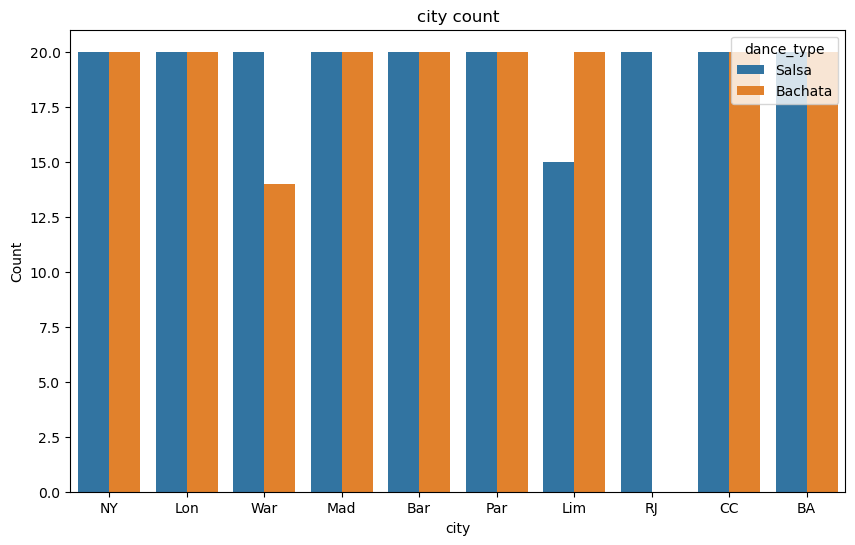

In [104]:
# Bar plot for each category
bar('city', normal = False)

Number of types: 13


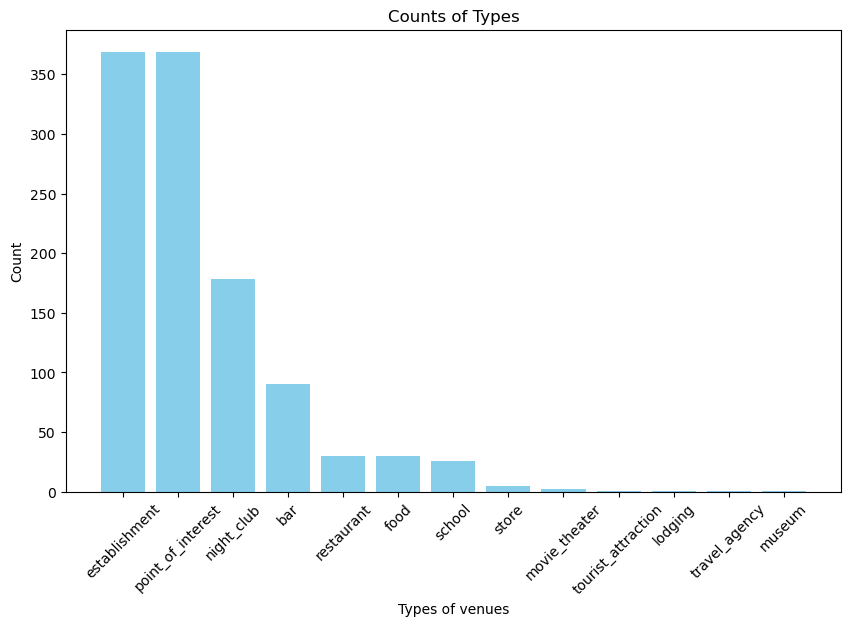

In [105]:
# Find number of unique types
import ast

# Change text to list in types column
df['types'] = df['types'].apply( lambda x : ast.literal_eval(x))

def flattened_type_list():
    types_list = []
    for type_list in df['types']:
        for type in type_list:
            types_list.append(type)
    return types_list
types_list = flattened_type_list()

unique_types = set(types_list)
print(f"Number of types: {len(unique_types)}")

# Plot histogram
from collections import Counter
def type_histo_plot(full_list, types_to_count):

    # Count occurence of each type in types_list

    category_counts = Counter(full_list)

    # Sort categories and counts in descending order
    sorted_categories, sorted_counts = zip(*sorted(
        [(category, category_counts[category]) for category in types_to_count],
        key=lambda x: x[1],
        reverse=True
    ))

    # Plotting the histogram using matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_categories, sorted_counts, color='skyblue', )


    # Adding labels and title
    plt.xlabel('Types of venues')
    plt.ylabel('Count')
    plt.title('Counts of Types')
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()
type_histo_plot(types_list, unique_types)


Number of types: 5


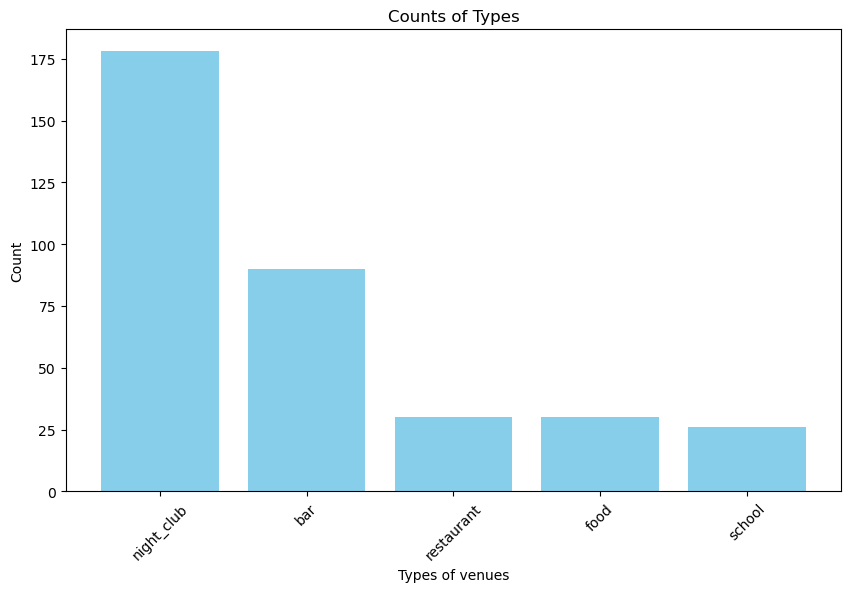

In [107]:
# Remove the two most common types, and remove the 6 least common types
# print(sorted_counts, sorted_categories)

# create list of types to remove
del_types_list = ('establishment', 'point_of_interest', 'store', 'movie_theater', 'tourist_attraction', 'lodging', 'travel_agency', 'museum')

# remove from each list in the types column
df['types'] = df['types'].apply(lambda x: [item for item in x if item not in del_types_list])

# create new flattened list of lists from types column
new_types_list = flattened_type_list()

# create new unique type list
unique_types = [item for item in unique_types if item not in del_types_list]
print(f"Number of types: {len(unique_types)}")   

# Plot new histogram
type_histo_plot(types_list, unique_types)

In [117]:
# Dealing with missing data
import missingno as msno

# Show number of non-null values, shows that there are 230 locations missing price_level values
# msno.bar(df)
# plt.show()

# Impute usiing the mean of the price_level
from sklearn.impute import SimpleImputer

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
df['price_level'] = np.ceil(imputer.fit_transform(df[['price_level']]))


In [119]:
df.describe()

,rating,user_ratings_total,price_level
count,369.000000,369.000000,369.000000
mean,4.388618,887.693767,1.940379
std,0.551560,1862.051249,0.340589
min,0.000000,0.000000,1.000000
25%,4.000000,74.000000,2.000000
50%,4.500000,261.000000,2.000000
75%,4.800000,853.000000,2.000000
max,5.000000,21498.000000,3.000000
